<a href="https://colab.research.google.com/github/YoshihiroOhtsuka-lab/JSTMHPE2026/blob/main/example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythonの実践例 #1



## 2つのグループの差の検定


## Pythonによる実践

### 分析の準備

pymcはWeb上からダウンロードする

In [ ]:
!pip install pymc

分析に必要なパッケージをあらかじめ、設定する。

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
#arvizの描画スタイルの設定
az.style.use("arviz-whitegrid")

図表に日本語を埋め込む場合には、別途インストールが必要

In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=9ba69e9ed3e6db005c2767db746c39709d30dd5dd55704ac499b62942e8e4741
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


### データの取得

今回、使用データを私のGithubにアップロードしておきました。

<Axes: xlabel='Group', ylabel='Score'>

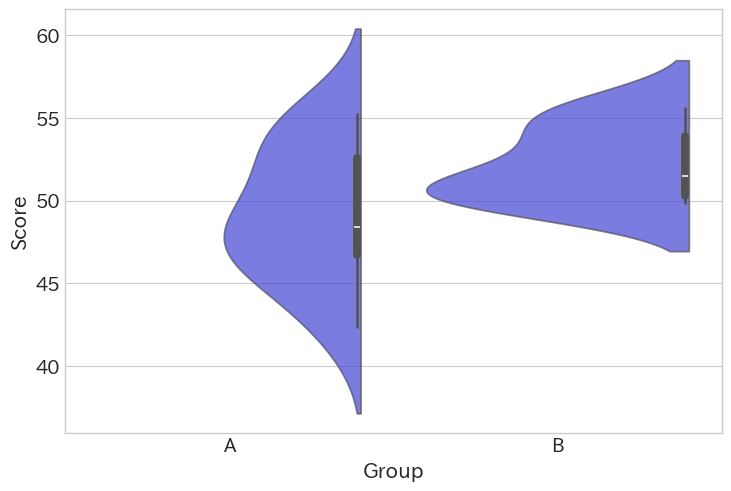

In [ ]:
# データのURL
url ='https://raw.githubusercontent.com/YoshihiroOhtsuka-lab/JSTMHPE2026/main/example1_data.xlsx'
df = pd.read_excel(url)

# ヴァイオリンプロットの作成
sns.violinplot(x='Group', y='Score', data=df, split=True, alpha=0.7)

変数の設定とカテゴリーの設定をします

In [ ]:
y = df['Score'].values
idx = pd.Categorical(df['Group']).codes

### Pymcの実装

Pymcでは、パラメータの事前分布とモデルの尤度を設定すれば終わりです。

#### モデル構造の定義

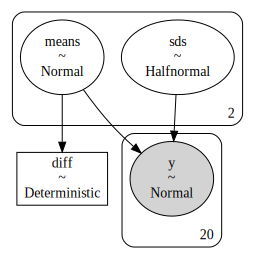

In [ ]:
with pm.Model() as comp_gr:
  # 平均と標準偏差の事前分布
  means = pm.Normal('means', mu= np.mean(y), sigma=pm.math.sqrt(10), shape=len(set(idx)))
  sds = pm.HalfNormal('sds', sigma=pm.math.sqrt(10), shape=len(set(idx)))
  # グループ差の事後分布を作成するために作成
  means_diff = pm.Deterministic('diff', means[0] - means[1])
  # 尤度設定
  y = pm.Normal('y', mu=means[idx], sigma=sds[idx], observed=y)

outline = pm.model_to_graphviz(comp_gr)
outline.render("outline", format="png", cleanup=True)
outline

#### MCMCの実装

Output()

            mean     sd  hdi_2.5%  hdi_97.5%
diff      -2.726  1.504    -5.654      0.309
means[0]  49.379  1.253    46.926     51.895
means[1]  52.105  0.793    50.536     53.670
sds[0]     4.193  0.900     2.609      5.972
sds[1]     2.522  0.616     1.519      3.754


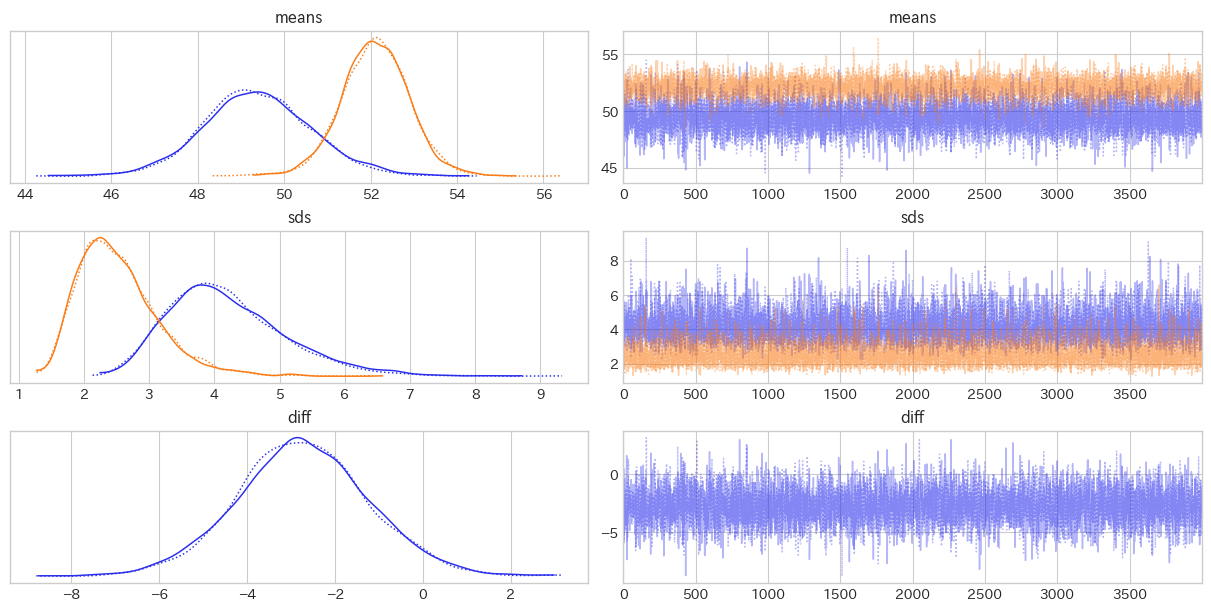

In [ ]:
n_draws = 4000
n_chains = 2
n_tunes = 1000

with comp_gr:
  # パラメータのサンプリング
  trace = pm.sample(draws=n_draws, chains=n_chains,
                    tune = n_tunes, random_seed=123
                    )
  # ベイズ因子を求める際に使用する
  trace.extend(pm.sample_prior_predictive(n_draws*n_chains))
  # 推定結果の出力
  print(pm.summary(trace, hdi_prob=0.95, kind='stats'))
  # 推定結果(事後分布と事後標本)の図示
  az.plot_trace(trace, var_names=['means', 'sds', 'diff'])

#### 差の分布を調べる

In [ ]:
# コーエンdの関数
def cohen_d(mean_dif, sig1, sig2):
  bottom = (sig1**2 + sig2**2)*0.5
  res = mean_dif / np.sqrt(bottom)

  return res.mean()

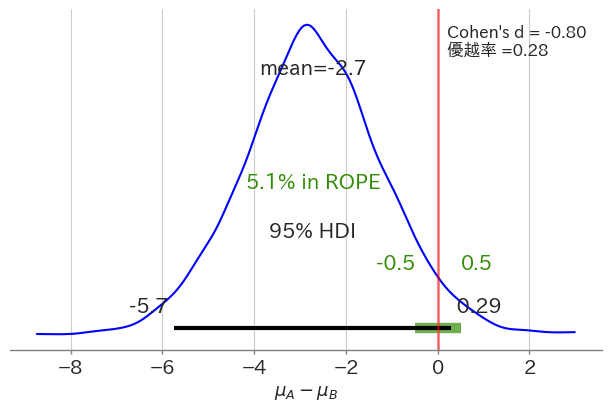

In [ ]:
# 事後標本データの受け渡し
pos_trace = trace.posterior
means_diff = pos_trace['diff'][0, :]

# コーエンdの計算
d_c = cohen_d(means_diff, pos_trace['sds'][0, :, 0], pos_trace['sds'][0, :, 1])

# 差の事後分布の作図
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
az.plot_posterior(means_diff, ax=ax1, color='blue',
                  hdi_prob=0.95, rope=[-0.5, 0.5])
ps = st.norm.cdf(d_c/(2**0.5))
ax1.set_xlabel('$\\mu_{A}-\\mu_{B}$', fontsize=13)
ax1.axvline(0, color='red', lw=2, alpha=0.5)
ax1.set_title("")
ax1.plot(0, label="Cohen's d = {:.2f}\n優越率 ={:.2f}".format(d_c, ps), alpha=0)
ax1.legend(loc=1, fontsize=12, frameon=False)
plt.show()

#### ベイズ因子の計算

まず、数値のみを出力する場合

In [ ]:
bf_res = az.bayes_factor(trace, var_name="diff", ref_val=0)
BF10 = bf_res["BF10"].round(3)
BF01 = bf_res["BF01"].round(3)
print("B_10 =", BF10)
print("B_01 =", BF01)

B_10 = 1.652
B_01 = 0.605


グラフィックで表示する場合

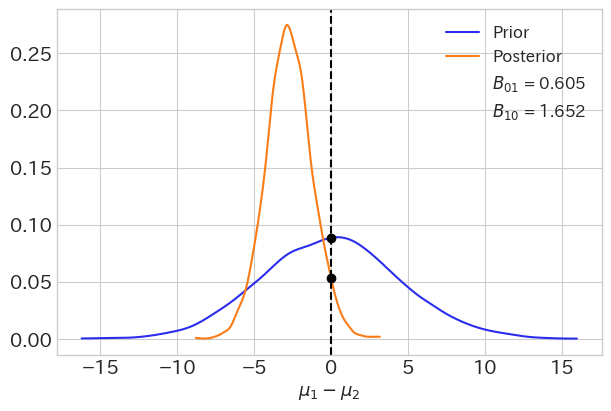

In [ ]:
_, ax2 = plt.subplots(1, 1, figsize=(6, 4))
az.plot_bf(trace, var_name='diff', ref_val=0, ax=ax2);
bfs = ax2.get_title()
ax2.set_xlabel('$\\mu_{1}-\\mu_{2}$', fontsize=13)
ax2.set_ylabel("")
#bf01 = np.log10(float(BF01)).round(2)
#bf10 = np.log10(float(BF10)).round(2)
ax2.plot(0,
         label="$B_{{01}}$ = {}".format(BF01),
         alpha=0)
ax2.plot(0,
         label="$B_{{10}}$ = {}".format(BF10),
         alpha=0)
ax2.set_title("")
ax2.legend(loc=1, fontsize=12, frameon=False)
plt.show()

### 平均値の差の検定

In [ ]:
y_1 = df.query('Group == "A"')
y_2 = df.query('Group == "B"')
tv, pv = st.ttest_ind(y_1['Score'], y_2['Score'], equal_var=False)
print("t値 =", tv.round(3))
print("p値 =", pv.round(3))

t値 = -2.045
p値 = 0.06
